In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
from scipy.special import ndtri
from scipy.stats import norm, lognorm
import aesara.tensor as at

import pickle


In [13]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_50 = pickle.load(file)

# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_25 = pickle.load(file)

# close file
file.close()

In [14]:
df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

results_decision_50.keys()
df = results_decision_50['11112']

In [15]:
mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0



In [16]:

import time

start_time = time.time()

# Add beta to stan_data, as it is used in the Stan model
beta = 0.88

# Prepare stan_data dictionary
stan_data = {
    'N': len(df),
    'gain': df['gain'].values,
    'loss': df['loss'].values,
    'prob_win': df['prob_win'].values,
    'prob_loss': df['prob_loss'].values,
    'prob_ambi': df['prob_ambi'].values,
    'invest': df['invest'].astype(int).values,
    'mu_theta': mu_theta,
    'sigma_theta': sig_theta,
    'mu_Lambda': mu_Lambda,
    'sigma_Lambda': sig_Lambda,
    'mu_tau': mu_tau,
    'sigma_tau': sig_tau,
    'mu_alpha': mu_alpha,
    'sigma_alpha': sig_alpha,
    'mu_gamma': mu_gamma,
    'sigma_gamma': sig_gamma,
    'sigma_error': sig_error,
    'beta': beta
}

import nest_asyncio
nest_asyncio.apply()





# # Set initial values for the parameters
# init_values = {
#     'theta': 0,
#     'Lambda': LAMBDA_INIT,
#     'tau': TAU_INIT,
#     'alpha': ALPHA_INIT,
#     'gamma': GAMMA_INIT,
#     'error': ERROR_INIT
# }



# Update Stan model code to accept beta as data
stan_model_code = """
data {
    int<lower=0> N; // number of observations
    vector[N] gain; // gains
    vector[N] loss; // losses
    vector[N] prob_win; // probability of winning
    vector[N] prob_loss; // probability of losing
    vector[N] prob_ambi; // probability of ambiguity
    array[N] int<lower=0, upper=1> invest; // observed investment decisions

    real mu_theta;
    real sigma_theta;
    real mu_Lambda;
    real sigma_Lambda;
    real mu_tau;
    real sigma_tau;
    real mu_alpha;
    real sigma_alpha;
    real mu_gamma;
    real sigma_gamma;
    real sigma_error;
    real beta; // <-- added beta as data
}

parameters {
    real<lower=0> theta; // parameter theta
    real<lower=0> Lambda; // parameter Lambda
    real<lower=0> tau; // parameter tau
    real<lower=0> alpha; // parameter alpha
    real<lower=0> gamma; // parameter gamma
    real error; // error term
}

model {
    // Priors
    theta ~ lognormal(mu_theta, sigma_theta);
    Lambda ~ lognormal(mu_Lambda, sigma_Lambda);
    tau ~ lognormal(mu_tau, sigma_tau);
    alpha ~ lognormal(mu_alpha, sigma_alpha);
    gamma ~ lognormal(mu_gamma, sigma_gamma);
    error ~ normal(0, sigma_error);

    // Likelihood
    for (n in 1:N) {
        real utility = (gain[n] >= 0 ? pow(gain[n], alpha) : -Lambda * pow(-gain[n], beta)) * 
                       pow(prob_win[n] + prob_ambi[n] * theta, gamma) +
                       (loss[n] >= 0 ? pow(loss[n], alpha) : -Lambda * pow(-loss[n], beta)) * 
                       pow(prob_loss[n] + prob_ambi[n] * (1 - theta), gamma);
        
        invest[n] ~ bernoulli_logit(tau * (utility - error));
    }
}
"""


# Compile the Stan model (synchronously in Jupyter)
posterior = stan.build(stan_model_code, data=stan_data)

# Fit the model
stan_fit = posterior.sample(num_chains=4, num_samples=1000)

stan_time = time.time() - start_time



Building...


Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  16% (1300/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  49% (3900/8000)
Sampling:  64% (5100/8000)
Sampling:  78% (6200/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during samp

<stan.Fit>
Parameters:
    theta: ()
    Lambda: ()
    tau: ()
    alpha: ()
    gamma: ()
    error: ()
Draws: 4000


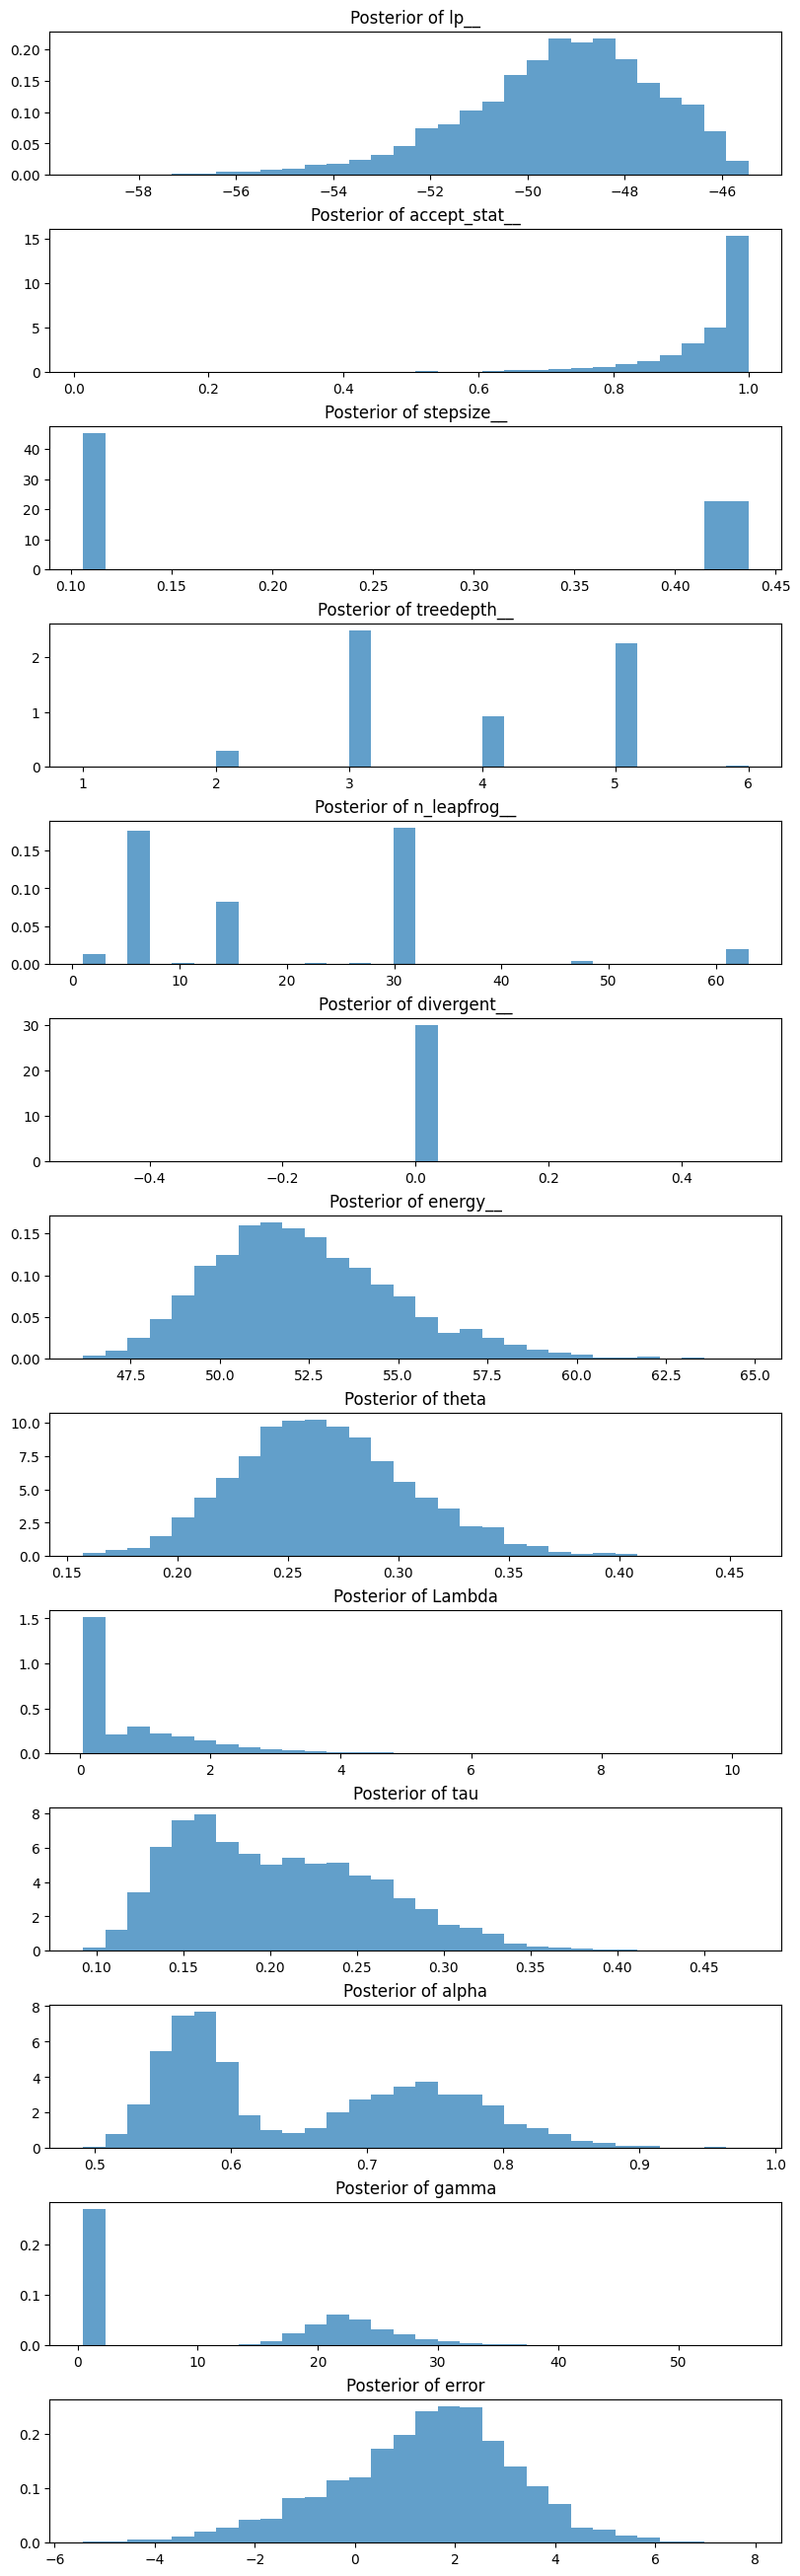

In [17]:
# Print the results
print(stan_fit)

# Plot posterior distributions for all parameters
import matplotlib.pyplot as plt

samples = stan_fit.to_frame()
fig, axes = plt.subplots(len(samples.columns), 1, figsize=(8, 2 * len(samples.columns)), constrained_layout=True)
if len(samples.columns) == 1:
	axes = [axes]
for ax, col in zip(axes, samples.columns):
	ax.hist(samples[col], bins=30, density=True, alpha=0.7)
	ax.set_title(f'Posterior of {col}')
plt.show()

In [18]:
print(stan_fit.to_frame().describe()[['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']].T)


             count       mean        std       min       25%       50%  \
parameters                                                               
theta       4000.0   0.266456   0.039828  0.157343  0.239165  0.263959   
Lambda      4000.0   0.881580   1.167853  0.048234  0.101729  0.182619   
tau         4000.0   0.204475   0.057196  0.092222  0.157669  0.195691   
alpha       4000.0   0.656542   0.096290  0.491749  0.571572  0.622084   
gamma       4000.0  11.831005  11.598548  0.449162  0.613080  6.516672   
error       4000.0   1.389292   1.811155 -5.433105  0.334426  1.573495   

                  75%        max  
parameters                        
theta        0.291703   0.458367  
Lambda       1.345377  10.251609  
tau          0.244667   0.475540  
alpha        0.740522   0.980047  
gamma       22.507689  55.825955  
error        2.580683   7.856698  


mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma      = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773


In [20]:
df.columns



Index(['trial_num', 'response_time', 'invest', 'prob_win', 'prob_loss',
       'prob_ambi', 'gain', 'loss', 'lottery_trial_num',
       'group_responsibility'],
      dtype='object')

In [21]:
 

# Helper functions rewritten for Aesara tensors

def lognormal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    shape  = sigma
    loc    = 0
    scale  = np.exp(mu)
    return lognorm.pdf(value, shape, loc, scale)

def normal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    loc    = 0
    scale  = sigma
    return norm.pdf(value, loc, scale)

def calc_eta(green, red, theta, prob_ambi):
    # prob_ambi is always provided in your data
    return green + prob_ambi * theta

def calc_subj_prob(prob, gamma):
    return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

def calc_subj_values(x, Lambda, alpha, beta):
    return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)

def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma, prob_ambi):
    prob_g = at.clip(calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
    prob_l = at.clip(calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
    u = (
        calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma) +
        calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma)
    )
    return u

def calc_prob_invest(utility, tau, error):
    return 1 / (1 + at.exp(-tau * (utility - error)))

In [27]:
from sklearn.metrics import roc_auc_score

FACTOR = 1 

theta   = stan_fit.to_frame()['theta'].mean()
Lambda  = stan_fit.to_frame()['Lambda'].mean()
alpha   = stan_fit.to_frame()['alpha'].mean()
tau     = stan_fit.to_frame()['tau'].mean()
beta    = beta  # already defined as 0.88
gamma   = stan_fit.to_frame()['gamma'].mean()
error  = stan_fit.to_frame()['error'].mean()

predictions = []

for _, row in df.iterrows():
    gain = row['gain'] * FACTOR
    loss = row['loss'] * FACTOR
    prob_win = row['prob_win']
    prob_loss = row['prob_loss']
    prob_ambi = row['prob_ambi']

    # Calculate subjective probabilities and values using numpy
    def np_calc_subj_values(x, Lambda, alpha, beta):
        return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

    def np_calc_eta(green, red, theta, prob_ambi):
        return green + prob_ambi * theta

    def np_calc_subj_prob(prob, gamma):
        return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

    prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
    prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
    subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
    subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
    subj_prob_g = np_calc_subj_prob(prob_g, gamma)
    subj_prob_l = np_calc_subj_prob(prob_l, gamma)
    utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

    # Probability to invest
    p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
    # Predict invest = 1 if p_invest > 0.5, else 0
    invest_pred = int(p_invest > 0.5)
    predictions.append(invest_pred)

# Calculate ROC AUC performance

y_true = df['invest'].values
y_pred = np.array(predictions)
try:
    roc_auc = roc_auc_score(y_true, y_pred)
except Exception:
    roc_auc = None  # In case only one class is present

print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.4384920634920635
